In order to preprocess the scans we need to resample and segment them. Does it matter what order we do it in? In terms of whether one leads to a more accurate representation of the original image.

Also exploring how long it'll take to chain these operations

In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom import dcmread
from skimage import measure, segmentation, morphology
from skimage.morphology import disk, opening, closing
%matplotlib inline

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [3]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [12]:
def resample(img, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing),
                      dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(img, real_resize_factor,
                                        mode='nearest')
    return image

In [73]:
def gen_internal_marker(slices_s, threshold= -300):
    internal_marker = slices_s < threshold
    internal_marker_labels = measure.label(segmentation.clear_border(internal_marker))
    areas = [x.area for x in measure.regionprops(internal_marker_labels)]
    areas.sort()
    for region in measure.regionprops(internal_marker_labels):
        if region.area < areas[-2]:
            for coordinates in region.coords:
                internal_marker_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = internal_marker_labels > 0
                
    return marker_internal

def gen_external_marker(internal_marker, iter_1 = 10, iter_2 = 50):
    external_a = ndimage.binary_dilation(internal_marker, 
                                         iterations=iter_1)
    external_b = ndimage.binary_dilation(internal_marker, 
                                         iterations=iter_2)
    external_marker = external_b ^ external_a
    return external_marker

def gen_watershed_marker(internal_marker, external_marker, shape):
    watershed_marker = np.zeros(shape, dtype=np.int)
    watershed_marker += internal_marker * 255
    watershed_marker += external_marker * 128
    return watershed_marker

def gen_sobel_grad(one_slice):
    x_edges = ndimage.sobel(one_slice, 1)
    y_edges = ndimage.sobel(one_slice, 0)
    sobel_grad = np.hypot(x_edges, y_edges)
    sobel_grad *= 255.0 / np.max(sobel_grad)
    return sobel_grad

def gen_blackhat_outline(watershed, blackhat_struct, b_hat_iters=1):
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    blackhat_kernel = ndimage.iterate_structure(blackhat_struct, 
                                               b_hat_iters)
    blackhat_outline = outline + ndimage.black_tophat(outline, 
                            structure=blackhat_kernel)
    return blackhat_outline

def gen_lung_filter(internal_marker, blackhat_outline,
                   kernel_size=(5,5), iterations=3):
    pre_filter = np.bitwise_or(internal_marker, blackhat_outline)
    lung_filter = ndimage.morphology.binary_closing(pre_filter,
                            structure=np.ones(kernel_size),
                            iterations=iterations)
    return lung_filter

def watershed_seg(slice_s, blackhat_struct, threshold=-350,
                  b_hat_iters=1, iter_1=10, iter_2=50):
    
    scan = [] #initialize an empty list
    for one_slice in slice_s:
        internal_marker = gen_internal_marker(one_slice)

        external_marker = gen_external_marker(internal_marker)
        
        watershed_marker = gen_watershed_marker(internal_marker,
                                               external_marker,
                                               one_slice.shape)
        
        sobel_grad = gen_sobel_grad(one_slice)
       
        watershed = segmentation.watershed(sobel_grad, 
                                           watershed_marker)
        
        blackhat_outline = gen_blackhat_outline(watershed,
                                blackhat_struct, b_hat_iters)
        
        lung_filter = gen_lung_filter(internal_marker,
                                      blackhat_outline)
        
        segmented_slice = np.where(lung_filter == 1, one_slice, -2000)
        scan.append(segmented_slice)
        
    return np.array(scan)

In [8]:
blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]

In [9]:
dcm = dcm_sort(train_path.ls()[0])
scan = ct_transformed(dcm)

In [14]:
%%timeit
resample(watershed_seg(scan, blackhat_struct), dcm)

17.8 s ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
#it'll take under an hour to do all
18*176/60

52.8

Lets look at what scans/slices look like when we do segmentation BEFORE resampling.

In [65]:
sb4 = resample(watershed_seg(scan, blackhat_struct), dcm)

In [66]:
sb4.shape, scan.shape

((335, 350, 350), (67, 512, 512))

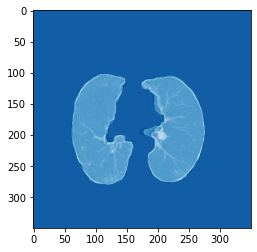

In [67]:
plt.imshow(sb4[200], cmap='Blues_r')

In [20]:
def plt_slices(scan):
    fig,ax = plt.subplots(12,5, figsize=(20,20))
    for n in range(12):
        for m in range(5):
            ax[n,m].imshow(scan[n*5+m], cmap='Blues_r')

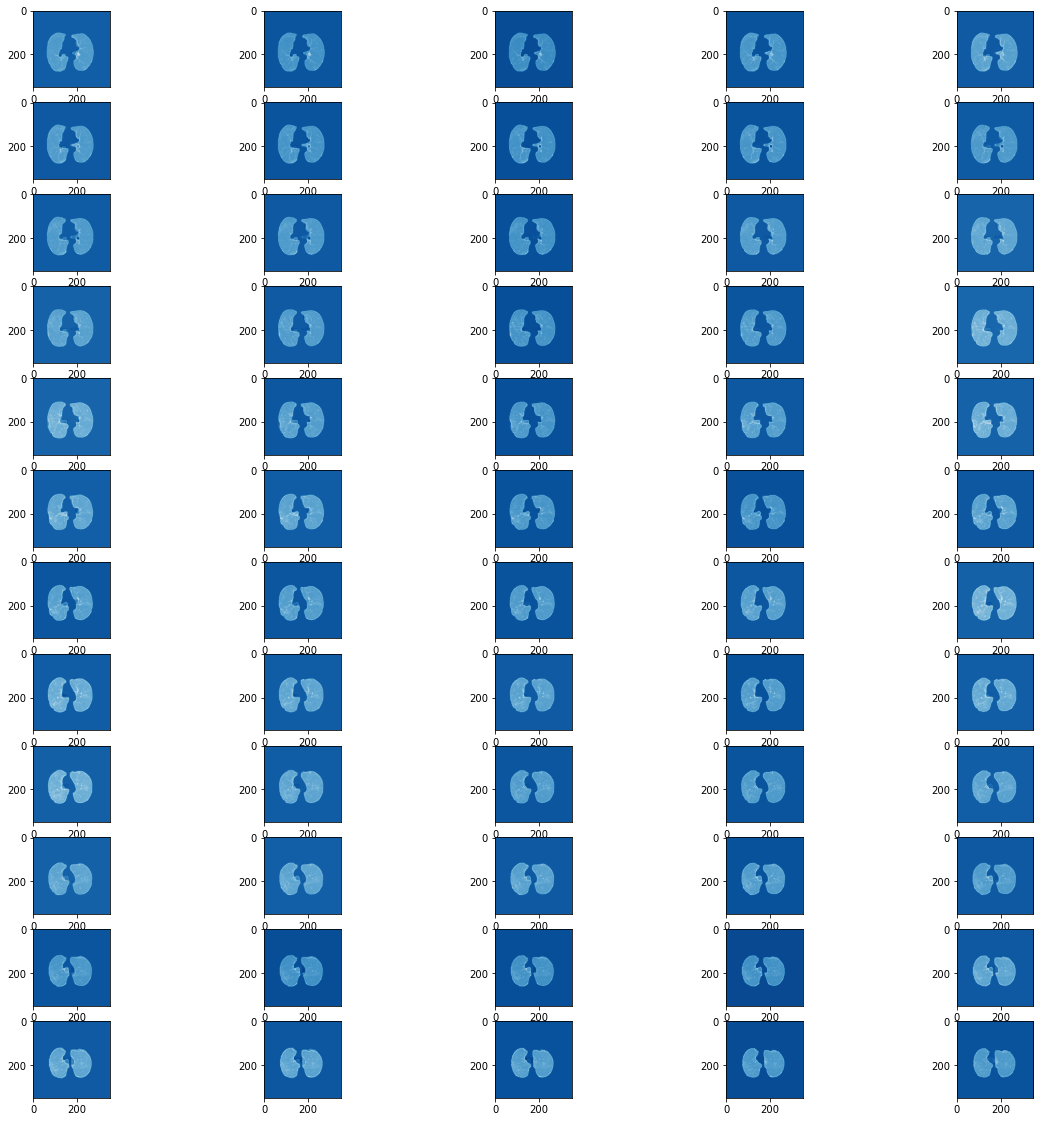

In [68]:
#we see alot of lungs(!)
plt_slices(sb4[200:])

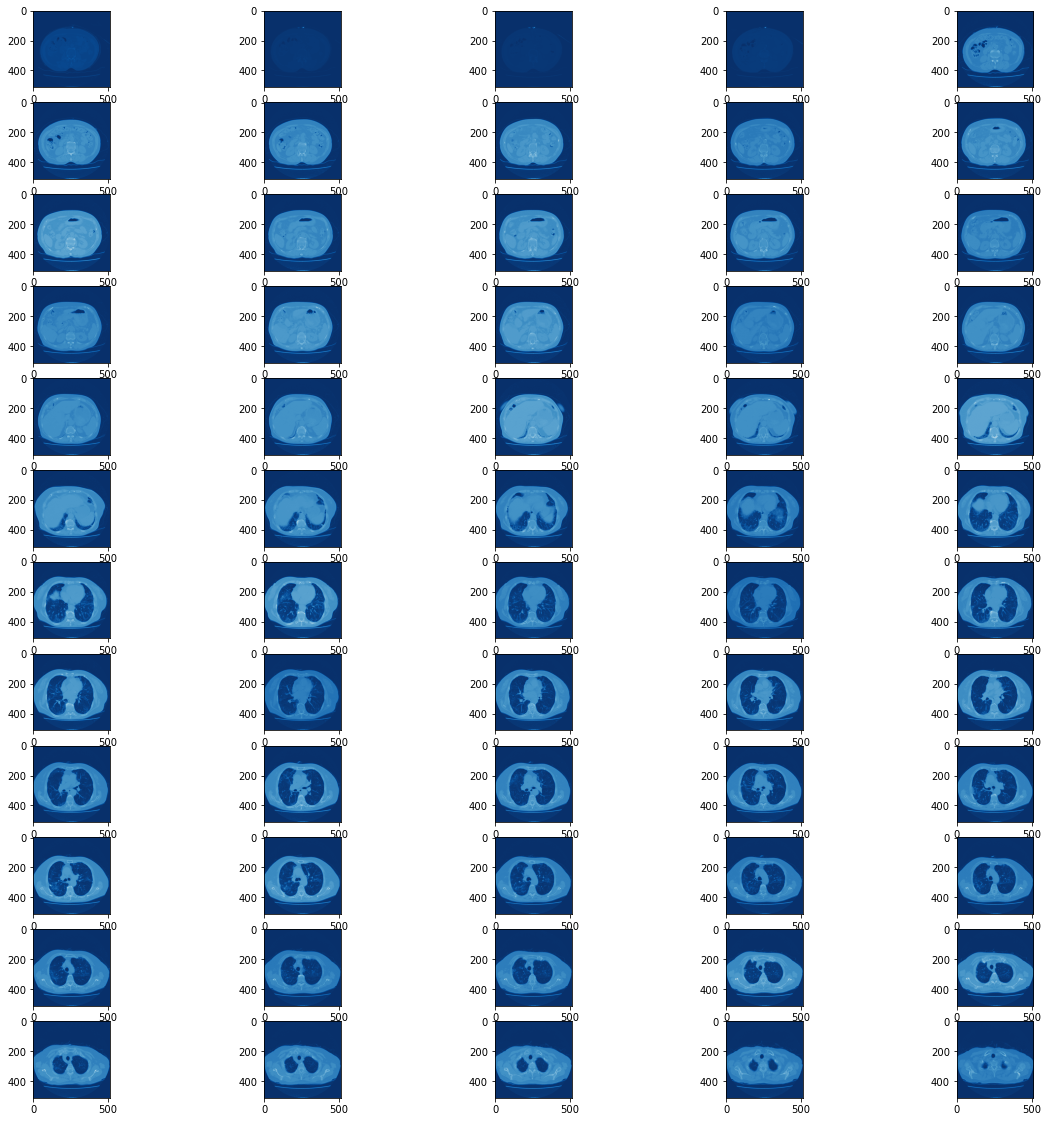

In [50]:
#looks like around 30 slices in you ge lungs -- 67 total in scan
plt_slices(scan)

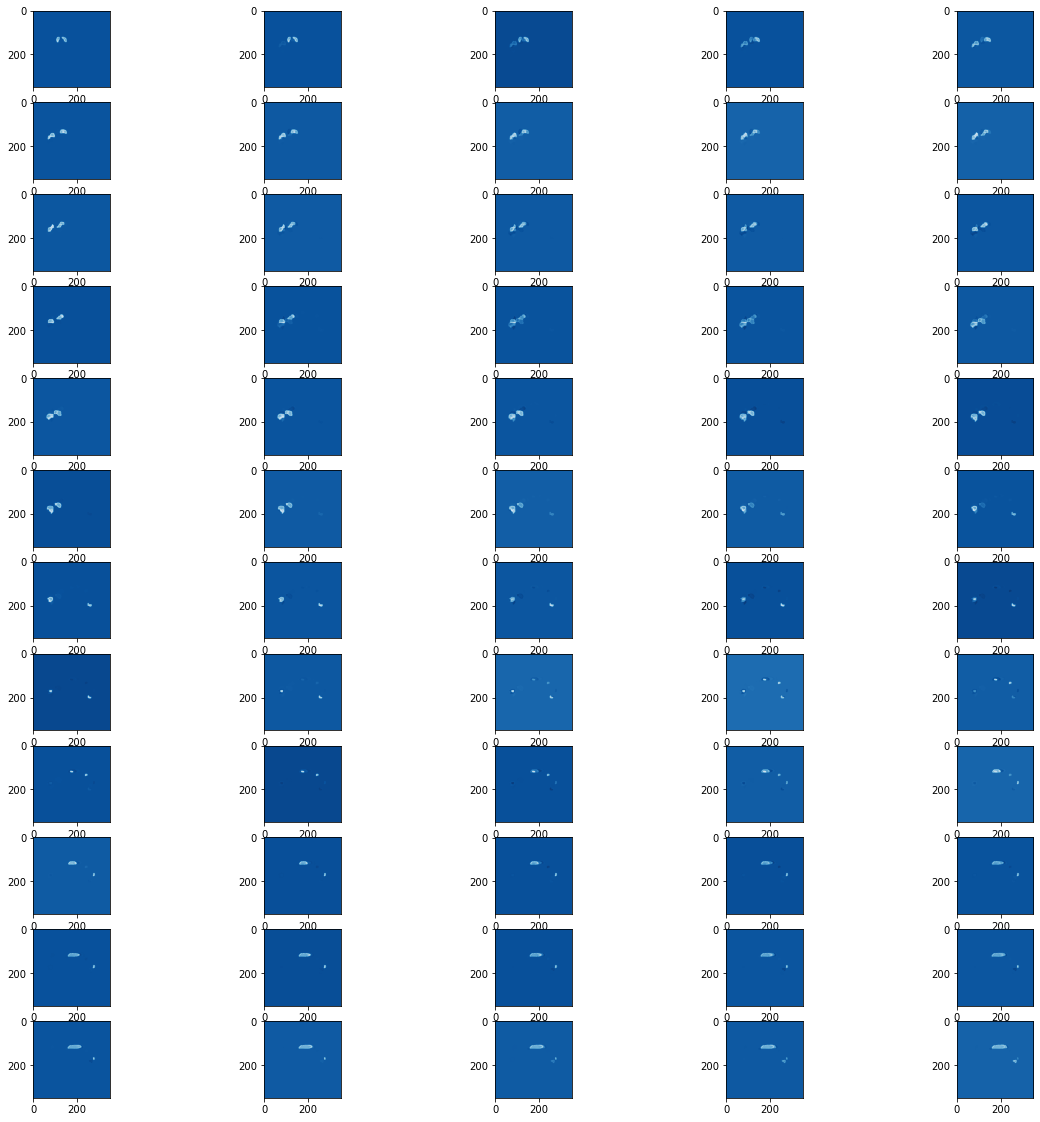

In [69]:
#that would explain all this dead space at the start of the scan
plt_slices(sb4)

In [44]:
#obviously having 335 channels after resample won't work
from scipy.ndimage.interpolation import zoom

In [70]:
#let's play around with the desired size
resize_fct = np.array([60, 100, 100]) / np.array(sb4.shape)
resize_fct

array([0.17910448, 0.28571429, 0.28571429])

In [71]:
zoomed = zoom(sb4, resize_fct)

In [47]:
zoomed.shape

(60, 100, 100)

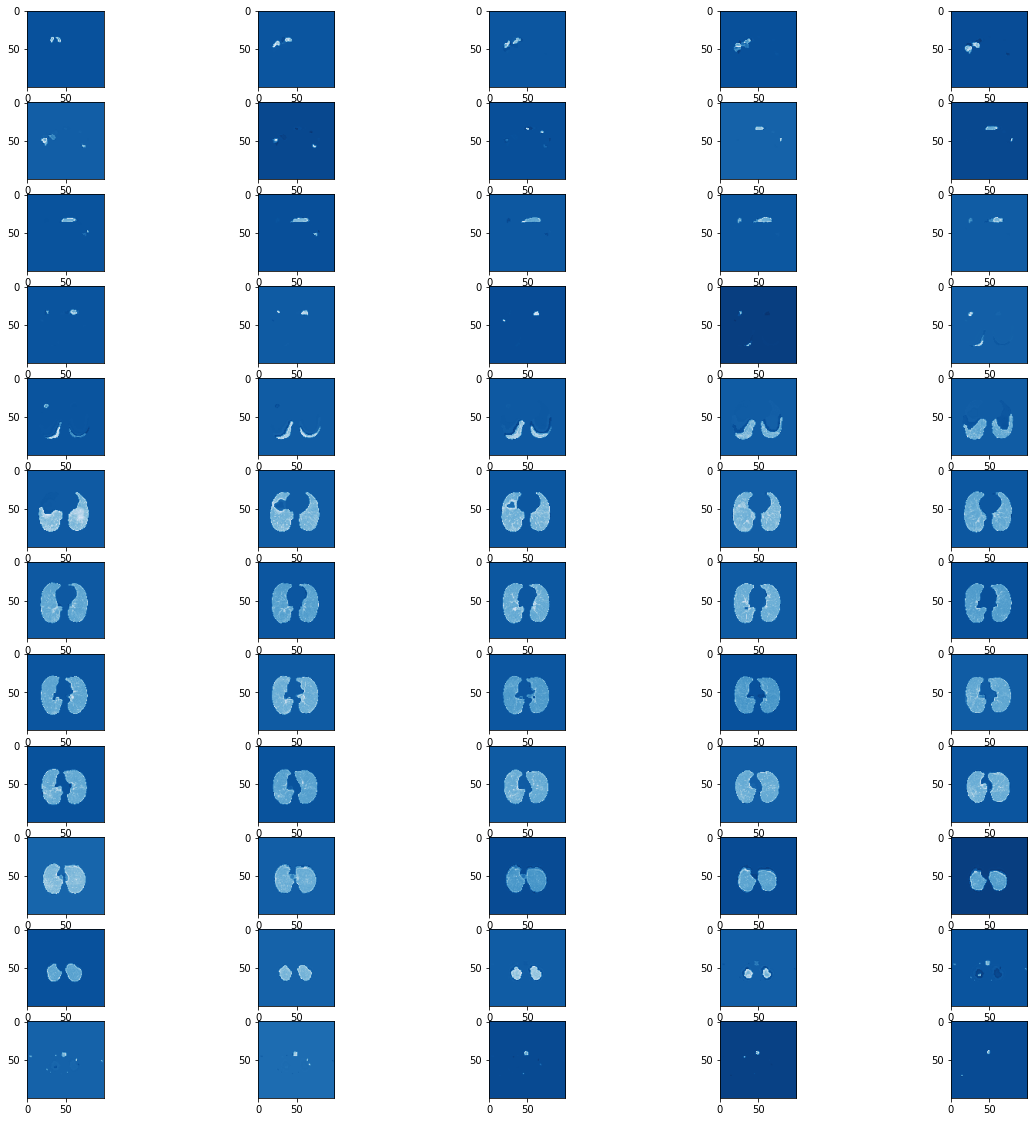

In [48]:
plt_slices(zoomed)

That looks like a closer representation to the original scan -- around 30 slices in you start seeing the lungs -- the last 10 - 15 in original scan they are hard to see, just like in the last ten in the zoom

Does the zoom make sense? I guess so since we've resampled the scan to have 1,1,1 volumetric data. We could probably scale that up to 3x3x3(?) Nonetheless this zoomed in scan is what we want to feed to the autoencoder

In [54]:
(60*100*100) / (67*512*512) 

0.03416146805037314

The resampled and resized scan is now 3% of the size of the original scan

Although 60x100x100 is still 600,000 pixels(!!!!) -- which around the same number of pixels a 3 channel 448 by 448 image is

In [60]:
448*448*3

602112

Now lets look at slices when we do resampling first and then the segmentaiton

In [74]:
rb4 = watershed_seg(resample(scan, dcm), blackhat_struct)

In [76]:
rb4.shape, sb4.shape

((335, 350, 350), (335, 350, 350))

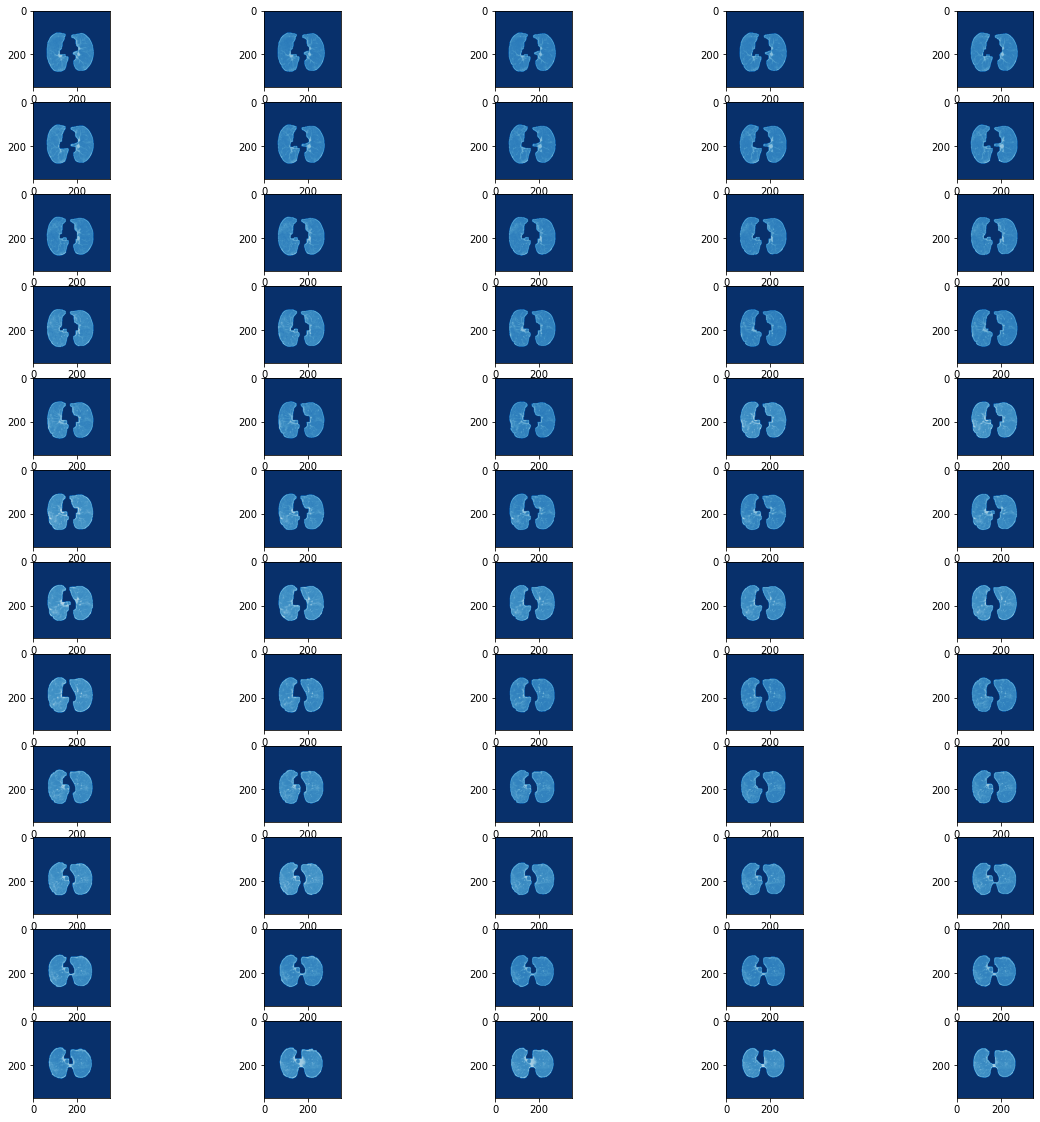

In [79]:
plt_slices(rb4[200:])

In [80]:
zoomed2 = zoom(rb4, resize_fct)

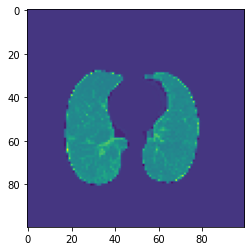

In [83]:
plt.imshow(zoomed[30])

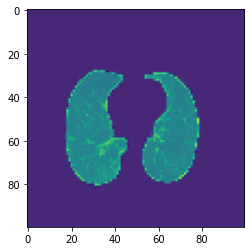

In [84]:
plt.imshow(zoomed2[30])

In [88]:
((zoomed2[30] - zoomed[30]) > 0).sum()

830

In [91]:
830/600000

0.0013833333333333334

So 0.1% of pixels are different between the two slices.... they also look visually the same. In theory perhaps it's better to do segmentation first so that the resampling has less noise(?) Idk.

Could generate two datasets with the two routes taken and see which one performs better when fed into models